### University of Washington: Machine Learning and Statistics 

# Lecture 9: Discriminative Classification

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 9.6-9.7
- [astroML website](https://www.astroml.org/index.html)
- `scikit-learn` documentation on [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) and [support vector machines](https://scikit-learn.org/stable/modules/svm.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML

In [1]:
pip install --pre -U astroml

  Using cached astroML-1.0.2-py3-none-any.whl (134 kB)
  Attempting uninstall: astroml
    Found existing installation: astroML 0.4.1
    Uninstalling astroML-0.4.1:
      Successfully uninstalled astroML-0.4.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm

In [3]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 150
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
cmap = cm.get_cmap('viridis')

In discriminative classification, instead of modeling the probability distribution of points of each class $k$, $p(x|y_k)$, we instead model the boundary between classes. One of the most successful methods are **random forests**, which we will build up to, starting with **decision trees**.

## Decision Trees
Let's remind ourself what our data looks like:

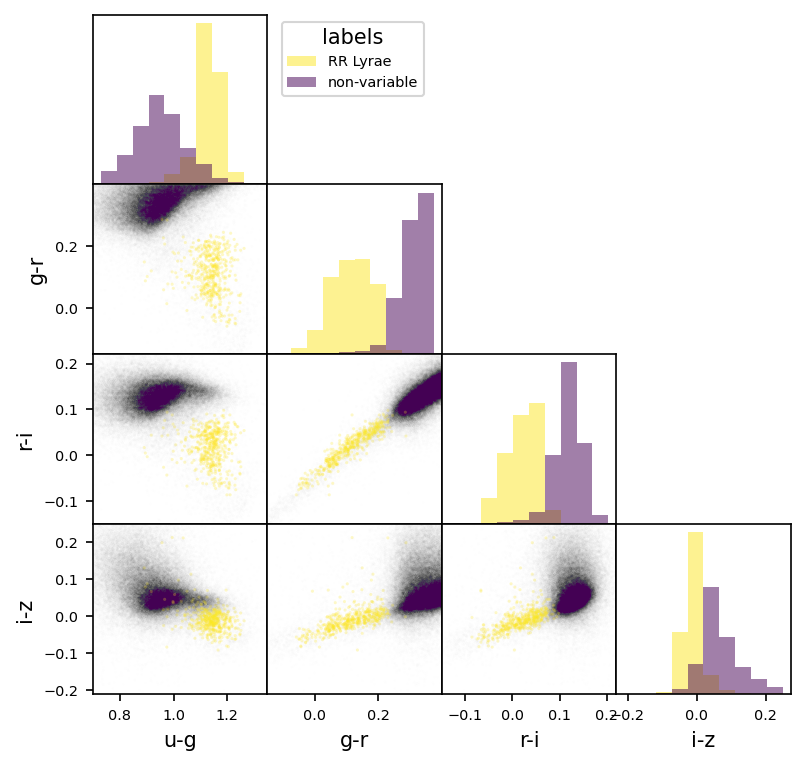

In [4]:
# fetch the data
X, y = fetch_rrlyrae_combined()
features = ['u-g', 'g-r', 'r-i', 'i-z']
labels = ['non-variable', 'RR Lyrae']

# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0, wspace=0)

# loop through every possible pair of features
for i in range(4):
    for j in range(4):
        # only make subplots in the lower diagonal
        if i <= j:
            ax = plt.subplot(4,4,i+j*4+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                ax.set_ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 3:
                ax.set_xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                ax.set_yticks([])
            if j != 3:
                ax.set_xticks([])
            # scatter plots in off diagonals
            if i < j:
                ax.scatter(X[y==0,i], X[y==0,j], s=1, marker='.', c=y[y==0], vmin=0, vmax=1, alpha=0.005)
                ax.scatter(X[y==1,i], X[y==1,j], s=1, marker='.', c=y[y==1], vmin=0, vmax=1, alpha=0.25)
                ax.set_xlim(np.min(X[:,i]), np.max(X[:,i]))
                ax.set_ylim(np.min(X[:,j]), np.max(X[:,j]))
            # normalized histograms on diagonals, with same colour map as scatter plots
            if i == j:
                plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='stepfilled',\
                         label=labels, color=[cmap(0.), cmap(1.)], alpha=0.5)

                plt.yticks([]) # don't want counts in the y-axis
                # add a legend
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
plt.show()

And let's take a look at a decision tree trained on this data:

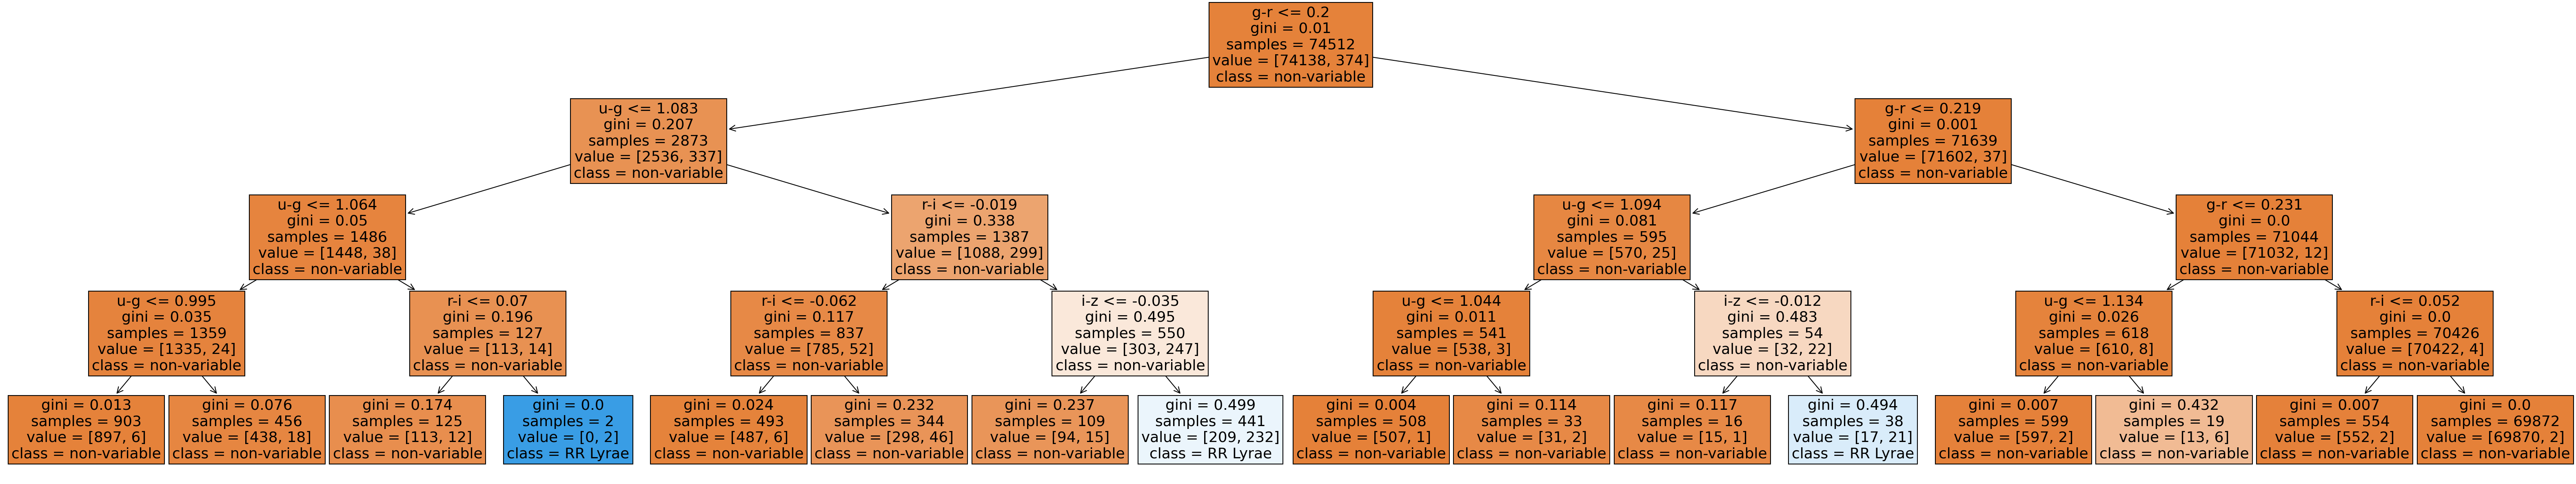

In [5]:
# train a decision tree with a depth up to 4
tree = DecisionTreeClassifier(random_state=0, max_depth=4)
tree.fit(X_train, y_train)
# plot this decision tree
plt.figure(figsize=(26,5))
plot_tree(tree, feature_names=features, class_names=labels, fontsize='xx-large', filled=True)
plt.show()

The tree starts with a **head node** that asks whether a feature is above or below a certain threshold, in this case, whether $g-r \leq 0.2$. If true, we go to the **child node** on the left, if false we go to the one on right. The left child node then asks whether $u-g \leq 1.083$, while the right child node asks whether $g-r \leq 0.219$. We can visualize these first two levels of nodes with a scatter plot:

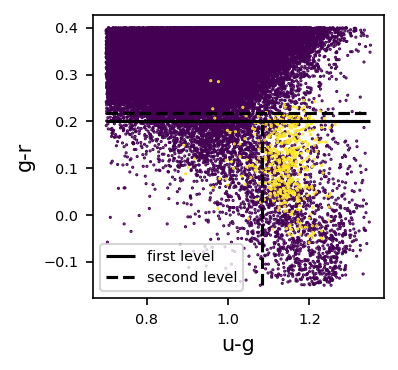

In [6]:
fig = plt.figure(figsize=(2.5,2.5))

plt.scatter(X[:,0], X[:,1], s=1, marker='.', c=y, cmap=cmap)
plt.xlabel(features[0])
plt.ylabel(features[1])

# This code is specific to the trained tree, and will not display the correct lines in general
plt.hlines(tree.tree_.threshold[0], xmin=np.min(X[:,0]), xmax=np.max(X[:,0]), label='first level', color='k')
plt.vlines(tree.tree_.threshold[1], ymin=np.min(X[:,1]), ymax=tree.tree_.threshold[0], ls='--', label='second level', color='k')
plt.hlines(tree.tree_.threshold[16], xmin=np.min(X[:,0]), xmax=np.max(X[:,0]), ls='--', color='k')

plt.legend()
plt.show()

We keep following nodes until we end at a leaf node that gives a classification decision. Decision trees are very interpretable, as we can manually determine where a new data point falls in the tree and why. But how do we build a decision tree? We need some criterion to decide the best next split to make. By default, `scikit-learn` uses the Gini criterion to evaluate possible child nodes:
$$ G = \sum_i p_i (1 - p_i)$$
where $p_i$ is the fraction of data points in a node that belong to class $i$. The Gini impurity is minimized with a value of zero for a node with only one class present, and is maximized for two classes when both classes have $p_i = 0.5$. Finding the series of splits that minimize the Gini impurities of the leaf nodes is difficult, so the tree is built one node at a time: the head node is the split that minimizes the summed Gini impurities of the two resulting child nodes, weighted by the number of data points in each node. The procedure is then repeated for each of the resulting child nodes until the specified depth of the tree is reached.

`scikit-learn` also supports using the information gain (`criterion = 'entropy'`) as the split criterion, where the entropy of a node is:
$$ E = - \sum_i p_i \log p_i $$
Again, the entropy is zero when a node only has members of one class, and is maximimized for two classes when both classes have $p_i = 0.5$. Minimizing the weighted sum of the entropies of the child nodes resulting from a split can be interpreted as maximizing the information gain from that split.

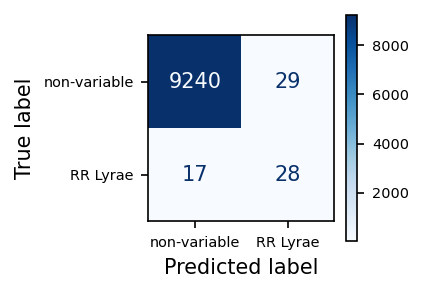

RR Lyrae Recall 0.622
RR Lyrae Precision 0.491


In [7]:
y_pred = tree.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

## Random Forests

Random forests are an **ensemble method**, where multiple decision trees are trained and the classification is based on a majority vote:

<img src="randomforest.png">

To make each tree different, two things are changed:
- Instead of training each tree on the entire dataset of $N$ points, a bootstrap sample of $N$ points is drawn from the dataset *with replacement* (duplicating some points and leaving others out)
- When the split decision is made for each node, splits are only allowed on a random subset of the features, forcing trees to make different splits

In [8]:
# train a random forest with 10 trees
forest = RandomForestClassifier(random_state=0, n_estimators=10)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

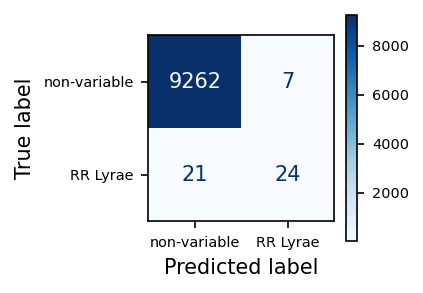

RR Lyrae Recall 0.533
RR Lyrae Precision 0.774


In [9]:
y_pred = forest.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

[Decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) can also be used for regression - instead of minimizing the Gini impurity or entropy, the split criterion will minimize the spread of values in a node. The regressor will use the average value of the training points that land in a node as the prediction for that node.

### Exercise
Try changing the number of trees in the random forest, `n_estimators`, and the number of features that are randomly selected at each split, `max_features`. Can you improve the precision and recall of the random forest?

## Kernel Support Vector Machines

Linear Support Vector Machines (SVM) find linear boundaries in feature space that maximize the margin between classes:

<img src="https://www.astroml.org/_images/fig_svm_diagram_1.png"> (Textbook Figure 9.9)

But the math behind them can be extended to find non-linear boundaries, using Kernel SVM. Consider the following data set with a non-linear class boundary:

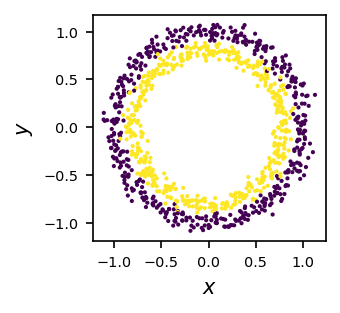

In [10]:
from sklearn.datasets import make_circles

X_svm, y_svm = make_circles(n_samples=1_000, noise=0.05, random_state=0)

plt.figure(figsize=(2,2))
plt.scatter(X_svm[:,0], X_svm[:,1], c=y_svm, s=1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

If we do *non-linear* transformations to the features, we can make this dataset *linearly* separable:

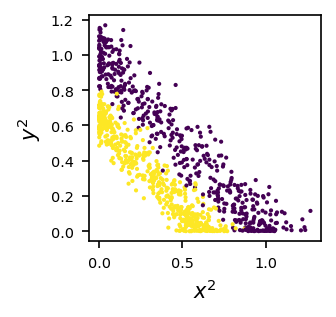

In [11]:
plt.figure(figsize=(2,2))
plt.scatter(X_svm[:,0]**2, X_svm[:,1]**2, c=y_svm, s=1)
plt.xlabel('$x^2$')
plt.ylabel('$y^2$')
plt.show()


Training linear SVM requires the dot product between pairs of data points, $\left< x, x' \right>$:

$$ {\arg \max}_\alpha \sum_i \alpha_i - \frac{1}{2} \sum_i \sum_{i'} \alpha_i \alpha_{i'} y_i y_{i'} \left< x_i, x_{i'} \right> \\
{\rm subject\ to\ } 0 \leq \alpha_i \leq C {\rm \ and\ } \sum_i \alpha_i y_i = 0$$

Kernel SVM generalizes this dot product into a kernel function $K(x,x')$, which can often be interpreted as a dot product in a higher dimensional space. For the commonly used Radial Basis Function kernel (RBF):
(adapted from [notes by Matthew Bernstein](https://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf))

$$K(x, x') = \exp \left(- \gamma \lVert x - x' \rVert^2\right) \\
= \exp \left(- \gamma \left[\lVert x \rVert^2 + \lVert x' \rVert^2 - 2 \left< x, x' \right> \right] \right) \\
= \exp \left(- \gamma \left[\lVert x \rVert^2 + \lVert x' \rVert^2\right] \right) \exp \left( 2 \gamma \left< x, x' \right> \right)$$

Defining $C \equiv \exp \left(- \gamma \left[\lVert x \rVert^2 + \lVert x' \rVert^2\right] \right)$ and expanding the exponential:
$$K(x, x') = C \sum_{n=1}^{\infty} \frac{(2 \gamma)^n}{n!} \left< x, x' \right>^n$$
defining $a_n \equiv (2 \gamma)^n / n!$ for brevity, and using subscripts to denote components:
$$K(x, x') = C \sum_{n=1}^{\infty} a_n \left< x, x' \right>^n = C \sum_{n=1}^{\infty} a_n \left(\sum_i x_i x'_i\right)^n\\
= C \left( a_1 \sum_i x_i x'_i + a_2 \left( \sum_i x_i x'_i \right) \left( \sum_j x_j x'_j \right) + a_3 \left( \sum_i x_i x'_i \right) \left( \sum_j x_j x'_j \right) \left( \sum_k x_k x'_k \right) + \cdots \right)\\
= C \left( a_1 \sum_i x_i x'_i + a_2 \sum_i \sum_j x_i x'_i x_j x'_j + a_3 \sum_i \sum_j \sum_k x_i x'_i x_j x'_j x_k x'_k + \cdots \right) \\
= C \left( a_1 \sum_i x_i x'_i + a_2 \sum_i \sum_j x_i x_j x'_i x'_j + a_3 \sum_i \sum_j \sum_k x_i x_j x_k x'_i x'_j x'_k + \cdots \right) $$
which would be the dot product of two vectors with components containing all natural number powers of $x_i$:
$$= \left<\frac{1}{\sqrt{C}} \left( \frac{x_i}{\sqrt{a_1}}, \frac{x_i x_j}{\sqrt{a_2}}, \frac{x_i x_j x_k}{\sqrt{a_3}}, \cdots \right), \frac{1}{\sqrt{C}} \left( \frac{x'_i}{\sqrt{a_1}}, \frac{x'_i x'_j}{\sqrt{a_2}}, \frac{x'_i x'_j x'_k}{\sqrt{a_3}}, \cdots \right)\right> $$
So Kernel SVM can be interpreted as finding a linear boundary in this higher dimensional space.

SVM is heavily affected by imbalanced data sets, so `class_weight = 'balanced'` downweights the more common non-variable stars. $\gamma$ is a very important hyperparameter to adjust, and lower $C$ corresponds to more regularization. SVM can take a long time to run when there are many data points.

In [12]:
svm = SVC(kernel='rbf', class_weight='balanced', gamma=1250, C=1) # SVC = Support Vector (Machine) Classifier
svm.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', gamma=1250)

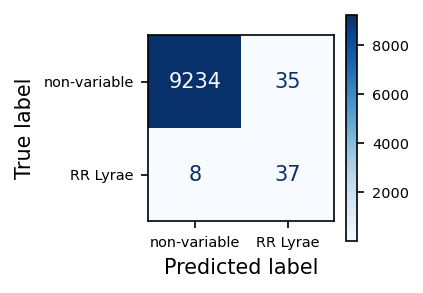

RR Lyrae Recall 0.822
RR Lyrae Precision 0.514


In [13]:
y_pred = svm.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))